## Data reading and Data Insights

**Listening to motivational podcasts Participant: julaag1s, 32 days participation**

*Dataset:* Listening to motivational podcasts (A) vs Not listening to motivational podcasts (B) (continue daily routine normally) study

#### Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
import pymc as pm
import arviz as az
import pytensor.tensor as pt
from pytensor.scan import scan


WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


In [2]:
path = "C://Users//USER//Desktop//StudyU_Results//"
df_intervention = pd.read_csv(path+"self-designed_n-of-1_trials_on_stress_management_-__listening_to_motivational_podcasts__-_julaag1s_2025-06-08 00_21_26.748//interventions.csv")
#print(df_intervention.head())
df_mea = pd.read_csv(path+"self-designed_n-of-1_trials_on_stress_management_-__listening_to_motivational_podcasts__-_julaag1s_2025-06-08 00_21_26.748//measurements.csv")
#print(df_mea.head())

## Data Analysis and Preprocessing

- Pre-analysis: julaag1s
    - Number of Participant
    - Participation of the study
    - Missing Values
    - Remove Participants Who Joined Outside the Study
    - Data Preperation

#### Number of Participant

In [3]:
column_name = 'participant_id' 

unique_count = df_intervention[column_name].nunique()

if unique_count == 1:
    only_value = df_intervention[column_name].iloc[0]
    print(f"The column '{column_name}' has only one unique value: {only_value!r}")
else:
    print(f"The column '{column_name}' has {unique_count} unique values.")
    print("Unique values are:", df_intervention[column_name].unique())

The column 'participant_id' has only one unique value: '645acc70-7be3-4916-9de5-6ac645b9c6e7'


#### Participation of the study

In [4]:
df_mea['measurement_time'] = pd.to_datetime(df_mea['measurement_time'], utc=True)

participation_days = (
    df_mea
    .groupby('participant_id')['measurement_time']
    .apply(lambda x: x.dt.date.nunique())
    .reset_index(name='participation_days')
)

print(participation_days)

                         participant_id  participation_days
0  645acc70-7be3-4916-9de5-6ac645b9c6e7                  31


The study comprised a single participant, with a total participation period of 31 days.

#### Missing Values

In [5]:
df_mea['measurement_time'] = pd.to_datetime(df_mea['measurement_time'])

results = {}

for pid in df_mea['participant_id'].unique():
    results[pid] = {}
    df_part = df_mea[df_mea['participant_id'] == pid]
    
    for name in ['Outcome', 'Mediators']:
        sub = df_part[df_part['measurement_name'] == name].copy()
        if sub.empty:
            results[pid][name] = None
            continue

        sub['date'] = sub['measurement_time'].dt.date

        start_date = sub['date'].min()

        expected_dates = pd.date_range(start_date, periods=32, freq='D').date

        done_dates = set(sub['date']) & set(expected_dates)

        missed_dates = sorted(set(expected_dates) - done_dates)

        results[pid][name] = {
            'start_date': start_date,
            'end_expected': expected_dates[-1],
            'expected_days': len(expected_dates),           
            'completed_days': len(done_dates),
            'missed_days_count': len(missed_dates),
            'missed_dates': missed_dates
        }

for pid, measures in results.items():
    print(f"\n--- Participant {pid} ---")
    for name, stats in measures.items():
        if stats is None:
            print(f"{name}: no data")
            continue
        print(f"\n  {name}:")
        print(f"    Start date:           {stats['start_date']}")
        print(f"    End of expected 16d:  {stats['end_expected']}")
        print(f"    Expected days count:  {stats['expected_days']}")
        print(f"    Completed days count: {stats['completed_days']}")
        print(f"    Missed days count:    {stats['missed_days_count']}")
        if stats['missed_dates']:
            print("    Missed dates:")
            for d in stats['missed_dates']:
                print("      ", d)


--- Participant 645acc70-7be3-4916-9de5-6ac645b9c6e7 ---

  Outcome:
    Start date:           2025-05-02
    End of expected 16d:  2025-06-02
    Expected days count:  32
    Completed days count: 31
    Missed days count:    1
    Missed dates:
       2025-05-17

  Mediators:
    Start date:           2025-05-02
    End of expected 16d:  2025-06-02
    Expected days count:  32
    Completed days count: 31
    Missed days count:    1
    Missed dates:
       2025-05-17


#### Remove Participants Who Joined Outside the Study

In [6]:
# df_mea = df_mea[df_mea['participant_id'] != "ca773388-eb42-4716-995a-476ed72c0475"]
# df_mea.shape[0]

#### Data Preperation

In [7]:
df_mea_all= df_mea[[
     'measurement_time',
     'measurement_name',
     'participant_id',
     'current_day_of_study',
     'current_intervention_name',
     'survey1_question1_response',
     'survey1_question2_response',
     'survey1_question3_response',
     'survey1_question4_response',
     'survey2_question1_response',
     'survey2_question2_response']]
df_mea_all.head(1)
    

,measurement_time,measurement_name,participant_id,current_day_of_study,current_intervention_name,survey1_question1_response,survey1_question2_response,survey1_question3_response,survey1_question4_response,survey2_question1_response,survey2_question2_response
0,2025-06-02 19:28:06.385823+00:00,Mediators,645acc70-7be3-4916-9de5-6ac645b9c6e7,31,Not listening to motivational podcasts!,NaN,NaN,NaN,NaN,7.0,8.0


In [8]:
df_mea_m = df_mea_all[df_mea_all['measurement_name'] == 'Mediators']
df_mea_o = df_mea_all[df_mea_all['measurement_name'] == 'Outcome']

In [9]:
df_mea_o = df_mea_o.sort_values(by=['participant_id', 'current_day_of_study'])
df_mea_m = df_mea_m.sort_values(by=['participant_id', 'current_day_of_study'])

In [10]:
df_mea_o.head()

,measurement_time,measurement_name,participant_id,current_day_of_study,current_intervention_name,survey1_question1_response,survey1_question2_response,survey1_question3_response,survey1_question4_response,survey2_question1_response,survey2_question2_response
61,2025-05-02 19:35:56.676737+00:00,Outcome,645acc70-7be3-4916-9de5-6ac645b9c6e7,0,Listening to motivational podcasts!,6.0,2.0,8.0,1.0,NaN,NaN
59,2025-05-03 19:48:08.447659+00:00,Outcome,645acc70-7be3-4916-9de5-6ac645b9c6e7,1,Listening to motivational podcasts!,3.0,4.0,7.0,1.0,NaN,NaN
57,2025-05-04 20:34:48.430635+00:00,Outcome,645acc70-7be3-4916-9de5-6ac645b9c6e7,2,Listening to motivational podcasts!,6.0,7.0,7.0,1.0,NaN,NaN
55,2025-05-05 19:12:12.312274+00:00,Outcome,645acc70-7be3-4916-9de5-6ac645b9c6e7,3,Listening to motivational podcasts!,8.0,9.0,9.0,1.0,NaN,NaN
53,2025-05-06 19:04:54.004311+00:00,Outcome,645acc70-7be3-4916-9de5-6ac645b9c6e7,4,Not listening to motivational podcasts!,6.0,6.0,10.0,1.0,NaN,NaN


## Exploratory Data Analysis - Outcome

- EDA Steps  
  - Data shape  
  - Data types of columns  
  - Missing values  
  - Summary statistics  
  - Data Visualization and Distributions  
    - Plot histograms and box plots  
    - Line plot  
    - Scatter plot  
    - Correlations (Pearson, Kendall, Spearman)     

#### Data Shape

In [11]:
print("Outcome Data Shape")
print("Rows:", df_mea_o.shape[0])
print("Columns:", df_mea_o.shape[1])

Outcome Data Shape
Rows: 31
Columns: 11


#### Data Types of columns

In [12]:
print("Outcome Data Types of Columns")
data_types = df_mea_o.dtypes
data_types_df = pd.DataFrame(data_types, columns=["Data Type"])
print(data_types_df)

Outcome Data Types of Columns
                                      Data Type
measurement_time            datetime64[ns, UTC]
measurement_name                         object
participant_id                           object
current_day_of_study                      int64
current_intervention_name                object
survey1_question1_response              float64
survey1_question2_response              float64
survey1_question3_response              float64
survey1_question4_response              float64
survey2_question1_response              float64
survey2_question2_response              float64


#### Missing Value Analysis

In [13]:
df_mea['measurement_time'] = pd.to_datetime(df_mea['measurement_time'])

df_mea.columns = df_mea.columns.str.strip()
df_mea['measurement_name'] = df_mea['measurement_name'].str.strip()

measurement_names = [
    'Outcome',
    'Mediators',
    'survey1_question1_response',
    'survey1_question2_response',
    'survey1_question3_response',
    'survey1_question4_response',
    'survey2_question1_response',
    'survey2_question2_response'
]

results = {}

for pid in df_mea['participant_id'].unique():
    results[pid] = {}
    df_part = df_mea[df_mea['participant_id'] == pid]
    
    for name in measurement_names:
        if name in ['Outcome', 'Mediators']:
            sub = df_part[df_part['measurement_name'] == name].copy()
        else:
            if name not in df_part.columns:
                sub = pd.DataFrame()
            else:
                sub = df_part[df_part[name].notna()].copy()
        
        if sub.empty:
            results[pid][name] = None
            continue

        sub['date'] = sub['measurement_time'].dt.date

        start_date = sub['date'].min()

        expected_dates = pd.date_range(start_date, periods=32, freq='D').date

        done_dates = set(sub['date']) & set(expected_dates)

        missed_dates = sorted(set(expected_dates) - done_dates)

        results[pid][name] = {
            'start_date': start_date,
            'end_expected': expected_dates[-1],
            'expected_days': len(expected_dates),      
            'completed_days': len(done_dates),
            'missed_days_count': len(missed_dates),
            'missed_dates': missed_dates
        }

for pid, measures in results.items():
    print(f"\n--- Participant {pid} ---")
    for name, stats in measures.items():
        if stats is None:
            print(f"{name}: no data")
            continue
        print(f"\n  {name}:")
        print(f"    Start date:           {stats['start_date']}")
        print(f"    End of expected 16d:  {stats['end_expected']}")
        print(f"    Expected days count:  {stats['expected_days']}")
        print(f"    Completed days count: {stats['completed_days']}")
        print(f"    Missed days count:    {stats['missed_days_count']}")
        if stats['missed_dates']:
            print("    Missed dates:")
            for d in stats['missed_dates']:
                print("      ", d)


--- Participant 645acc70-7be3-4916-9de5-6ac645b9c6e7 ---

  Outcome:
    Start date:           2025-05-02
    End of expected 16d:  2025-06-02
    Expected days count:  32
    Completed days count: 31
    Missed days count:    1
    Missed dates:
       2025-05-17

  Mediators:
    Start date:           2025-05-02
    End of expected 16d:  2025-06-02
    Expected days count:  32
    Completed days count: 31
    Missed days count:    1
    Missed dates:
       2025-05-17

  survey1_question1_response:
    Start date:           2025-05-02
    End of expected 16d:  2025-06-02
    Expected days count:  32
    Completed days count: 31
    Missed days count:    1
    Missed dates:
       2025-05-17

  survey1_question2_response:
    Start date:           2025-05-02
    End of expected 16d:  2025-06-02
    Expected days count:  32
    Completed days count: 31
    Missed days count:    1
    Missed dates:
       2025-05-17

  survey1_question3_response:
    Start date:           2025-05-02
  

#### Missing Values for Confirmations between 08.00 - 21.00

In [14]:
df_intervention['intervention_task_time'] = pd.to_datetime(
    df_intervention['intervention_task_time'],
    errors='coerce'
)

df_intervention['date'] = df_intervention['intervention_task_time'].dt.date

start_date = df_intervention['date'].min()
full_range = pd.date_range(start=start_date, periods=32, freq='D').date

full_df = pd.DataFrame({'date': full_range})
merged = full_df.merge(
    df_intervention[['date', 'intervention_task_name']],
    on='date',
    how='left'
)

missing_days = merged[merged['intervention_task_name'].isna()]

if missing_days.empty:
    print("All 32 days have participation confirmations; no missing days found.")
else:
    print("Missing participation days and their corresponding task names:")
    print(missing_days)

All 32 days have participation confirmations; no missing days found.


#### Summary Statistics

In [15]:
print("Sleep Data Summary Statistics")
summary_stats = df_mea_o.describe()
print(summary_stats)

Sleep Data Summary Statistics
       current_day_of_study  survey1_question1_response  \
count             31.000000                   31.000000   
mean              15.516129                    7.612903   
std                9.535446                    1.406590   
min                0.000000                    3.000000   
25%                7.500000                    7.000000   
50%               16.000000                    8.000000   
75%               23.500000                    8.000000   
max               31.000000                   10.000000   

       survey1_question2_response  survey1_question3_response  \
count                   31.000000                   31.000000   
mean                     7.612903                    5.580645   
std                      1.838068                    3.432921   
min                      2.000000                    1.000000   
25%                      7.000000                    1.000000   
50%                      8.000000               

In [16]:
df_mea_o.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31 entries, 61 to 1
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   measurement_time            31 non-null     datetime64[ns, UTC]
 1   measurement_name            31 non-null     object             
 2   participant_id              31 non-null     object             
 3   current_day_of_study        31 non-null     int64              
 4   current_intervention_name   31 non-null     object             
 5   survey1_question1_response  31 non-null     float64            
 6   survey1_question2_response  31 non-null     float64            
 7   survey1_question3_response  31 non-null     float64            
 8   survey1_question4_response  31 non-null     float64            
 9   survey2_question1_response  0 non-null      float64            
 10  survey2_question2_response  0 non-null      float64            
dtype

#### Data Visualization and Distributions

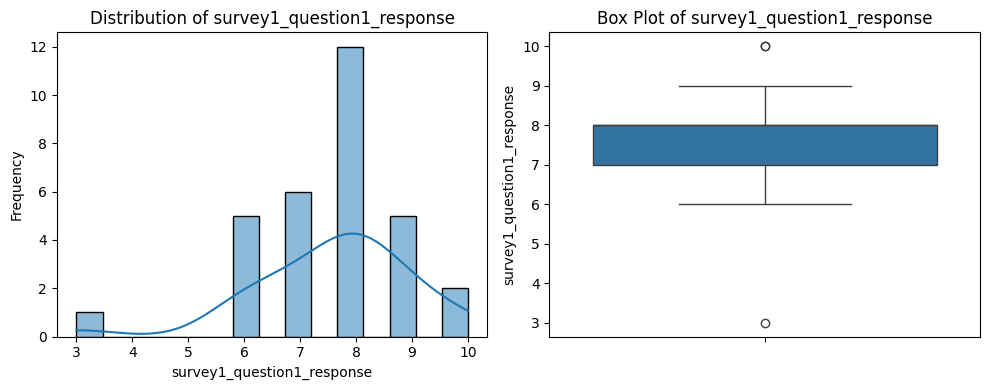

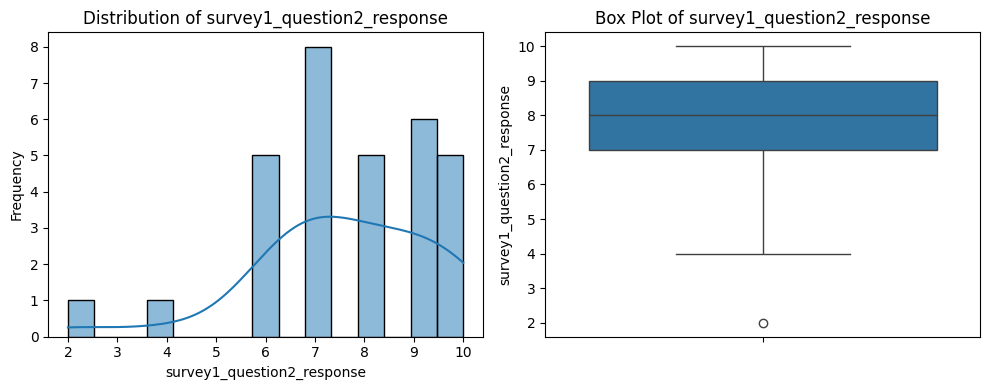

In [17]:
columns = [
    'survey1_question1_response',
    'survey1_question2_response']
for column in columns:
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    sns.histplot(df_mea_o[column].dropna(), bins=15, kde=True)
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")

    plt.subplot(1, 2, 2)
    sns.boxplot(y=df_mea_o[column].dropna())
    plt.title(f"Box Plot of {column}")
    plt.ylabel(column)

    plt.tight_layout()
    plt.show()

#### Line Plot

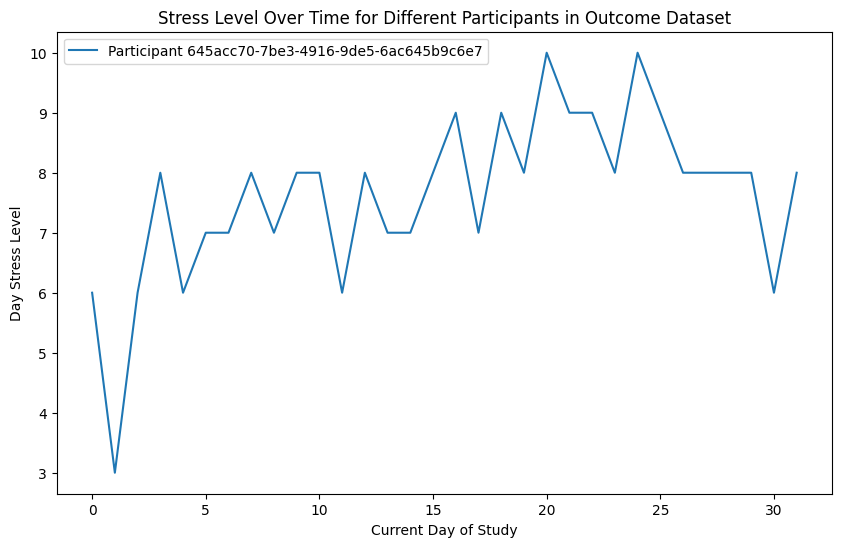

In [18]:
grouped_data = df_mea_o.groupby("participant_id")

plt.figure(figsize=(10, 6)) 

for participant_id, group in grouped_data:
    plt.plot(group['current_day_of_study'], group['survey1_question1_response'], label=f'Participant {participant_id}')

plt.xlabel('Current Day of Study')
plt.ylabel('Day Stress Level')
plt.title('Stress Level Over Time for Different Participants in Outcome Dataset')

plt.legend()
plt.show()

#### Scatterplot

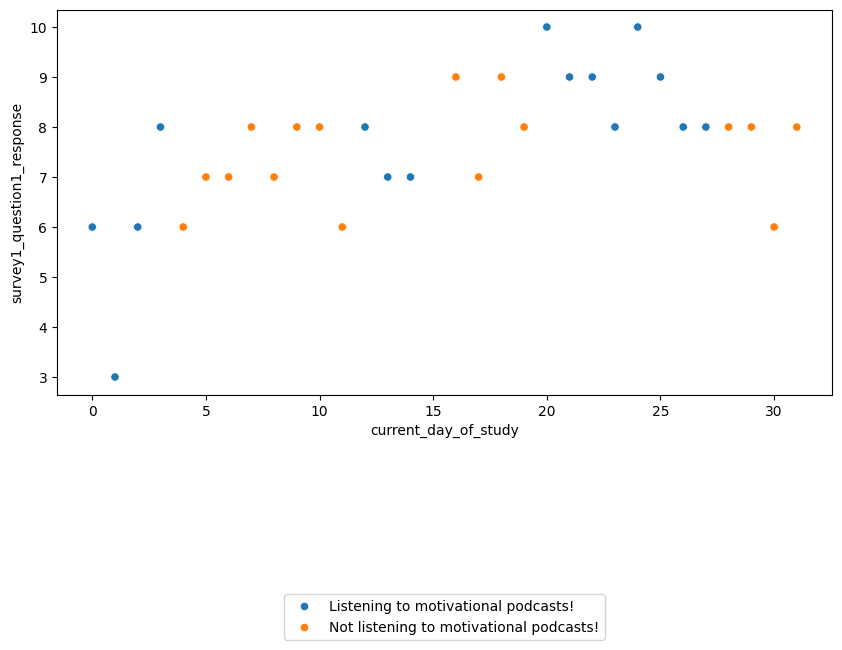

In [19]:
x = 'current_day_of_study'
y = 'survey1_question1_response'

participant_list= list(df_mea_o.participant_id.unique())
fig, axs = plt.subplots(len(participant_list), figsize=(10, 5 * len(participant_list)))

if len(participant_list) == 1:
    axs = [axs]

for i in range(len(participant_list)):
    legend = True if i == len(participant_list)-1 else False
    sns.scatterplot(
        data=df_mea_o[df_mea_o["participant_id"] == participant_list[i]],
        x=x, y=y, hue='current_intervention_name',
        ax=axs[i], legend=legend
    )

axs[-1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.5))

#### Correlations

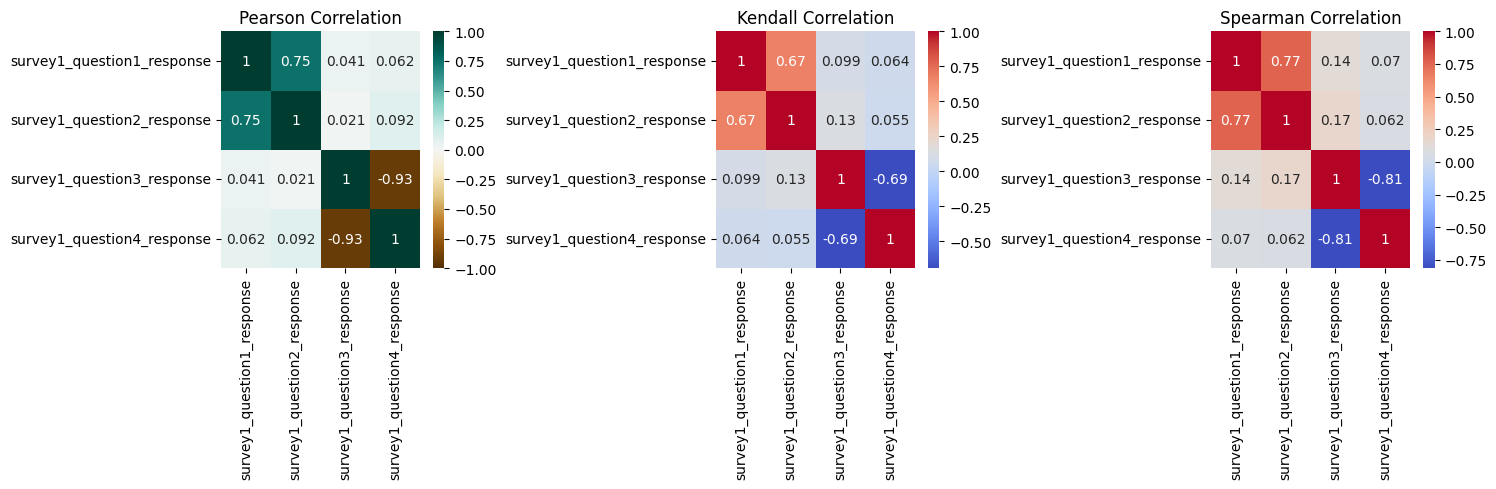

In [20]:
columns_to_include = [
    'survey1_question1_response',
    'survey1_question2_response',
    'survey1_question3_response',
    'survey1_question4_response']

correlation_pearson = df_mea_all[columns_to_include].corr(method='pearson')
correlation_kendall = df_mea_all[columns_to_include].corr(method='kendall')
correlation_spearman = df_mea_all[columns_to_include].corr(method='spearman')

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.heatmap(correlation_pearson, vmin=-1, vmax=1, annot=True, cmap='BrBG',ax=axes[0], center=0)
axes[0].set_title('Pearson Correlation')

sns.heatmap(correlation_kendall, annot=True, cmap='coolwarm', ax=axes[1])
axes[1].set_title('Kendall Correlation')

sns.heatmap(correlation_spearman, annot=True, cmap='coolwarm', ax=axes[2])
axes[2].set_title('Spearman Correlation')

plt.tight_layout()
plt.show()

## Baseline Study: Listening to Motivational Podcast vs Not Listening to Podcasts

  - Baseline Studies  
    - Examination of Outcomes   
    - Linear Regression  
      - Ordinary Least Squares (OLS) Regression  
      - Linear Regression with Autoregressive Errors 
      - Bayesian linear regression models
        - Bayesian AR(1) Model of Daily Stress Response to Intervention and Mediators
        - Bayesian AR(1) Regression with Data-Driven Scale (MAD-Based)
        - Bayesian AR(1) Regression with Consecutive‐Day Adjustment
        - Bayesian AR(1) Model of Daily Stress Response to Intervention and Mediators - Mean Imputation Method
        - Bayesian AR(1) Model of Daily Stress Response to Intervention and Mediators - Latent Variable Method

#### Examination of Outcomes: Today Stress Level

In [22]:
df_mea_o = df_mea_o[
    (df_mea_o['measurement_name'] == 'Outcome') &
    df_mea_o['survey1_question1_response'].notna() &
    df_mea_o['current_intervention_name'].isin([
        "Listening to motivational podcasts!",
        "Not listening to motivational podcasts!"
    ])
]

motivational = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "Listening to motivational podcasts!",
    'survey1_question1_response'
]
no_motivational = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "Not listening to motivational podcasts!",
    'survey1_question1_response'
]

n_motivational        = motivational.count()
n_no_motivational     = no_motivational.count()
std_motivational      = motivational.std(ddof=1)
std_no_motivational   = no_motivational.std(ddof=1)

print(f"Listening to motivational podcasts:                          n = {n_motivational}, std = {std_motivational:.2f}, mean = {motivational.mean():.2f}")
print(f"Not listening to motivational podcasts (daily routine normal): n = {n_no_motivational}, std = {std_no_motivational:.2f}, mean = {no_motivational.mean():.2f}\n")

Listening to motivational podcasts:                          n = 15, std = 1.79, mean = 7.73
Not listening to motivational podcasts (daily routine normal): n = 16, std = 0.97, mean = 7.50



#### Examination of Outcomes: Prediction of Tomorrow Stress

In [23]:
df_mea_o = df_mea_o[
    (df_mea_o['measurement_name'] == 'Outcome') &
    df_mea_o['survey1_question2_response'].notna() &
    df_mea_o['current_intervention_name'].isin([
        "Listening to motivational podcasts!",
        "Not listening to motivational podcasts!"
    ])
]

motivational = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "Listening to motivational podcasts!",
    'survey1_question2_response'
]
no_motivational = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "Not listening to motivational podcasts!",
    'survey1_question2_response'
]

n_motivational        = motivational.count()
n_no_motivational     = no_motivational.count()
std_motivational      = motivational.std(ddof=1)
std_no_motivational   = no_motivational.std(ddof=1)

print(f"Listening to motivational podcasts:                          n = {n_motivational}, std = {std_motivational:.2f}, mean = {motivational.mean():.2f}")
print(f"Not listening to motivational podcasts (daily routine normal): n = {n_no_motivational}, std = {std_no_motivational:.2f}, mean = {no_motivational.mean():.2f}\n")

Listening to motivational podcasts:                          n = 15, std = 2.37, mean = 7.80
Not listening to motivational podcasts (daily routine normal): n = 16, std = 1.21, mean = 7.44



#### Examination of Outcomes: Mean Stress-Relief Score for Listening to Motivational Podcasts! (Q3)
The average score for Question 3 (survey1_question3_response), which assesses how much listening to motivational podcasts alleviated participants’ stress on days they performed.

In [24]:
df_mea.survey1_question3_text[0]

'How much did this method (listening to motivational podcasts) help you feel better about yourself? <b>(Answer ONLY if you have listened to motivational podcasts!)</b>'

In [25]:
# 'How much did this method (listening to motivational podcasts) help you feel better about yourself? <b>(Answer ONLY if you have listened to motivational podcasts!)</b>'
mean_q3_listening_motivational = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "Listening to motivational podcasts!",
    'survey1_question3_response'
].mean()
mean_q3_listening_motivational.item()

7.866666666666666

**Mean Self-Improvement Score for Listening to Motivational Podcasts (Q3): 7.87:**
On days when the participant listened to motivational podcasts, he rated Question 3—“How much did this method (listening to motivational podcasts) help you feel better about yourself?”—an average of **7.87 out of 10**, indicating that listening to motivational podcasts provided a substantial boost in how much better he felt.


#### Examination of Outcomes: Mean Stress-Management Difficulty Without Listening to Motivational Podcasts (Q4)
The average score for Question 4 (survey1_question4_response), which measures participants’ difficulty in managing stress on days they did not listen to motivational podcasts.

In [26]:
df_mea.survey1_question4_text[0]

'When you are not practicing the method (not listening to motivational podcasts) today, do you feel a lack or difficulty managing your stress? <b>(Answer ONLY if you have NOT listened to motivational podcasts!)</b>'

In [27]:
# 'When you are not practicing the method (not listening to motivational podcasts) today, do you feel a lack or difficulty managing your stress? <b>(Answer ONLY if you have NOT listened to motivational podcasts!)</b>'
mean_q4_no_listening_motivational = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "Not listening to motivational podcasts!",
    'survey1_question4_response'
].mean()
mean_q4_no_listening_motivational.item()


5.3125

**Mean Stress-Management Difficulty Score Without Listening to Motivational Podcasts (Q4): 5.31:**
On days when the participant did not listen to motivational podcasts, he rated Question 4—“When you are not practicing the method (not listening to motivational podcasts) today, do you feel a lack or difficulty managing your stress?”—an average of **5.31 out of 10**, indicating that going without motivational podcasts posed a moderate challenge to his stress management.

#### Estimating treatment effect using Linear Regression with Autoregressive errors

In [28]:
df_mea_o = df_mea_o[
    (df_mea_o['measurement_name'] == 'Outcome') &
    df_mea_o['survey1_question1_response'].notna() &
    df_mea_o['current_intervention_name'].isin(["Listening to motivational podcasts!", "Not listening to motivational podcasts!"])
]

df_mea_o = df_mea_o.sort_values('measurement_time')

y = df_mea_o['survey1_question1_response']
df_mea_o['D'] = (df_mea_o['current_intervention_name'] == "Listening to motivational podcasts!").astype(int)
X = sm.add_constant(df_mea_o['D'])

ols_res = sm.OLS(y, X).fit()
dw_ols = durbin_watson(ols_res.resid)

print("OLS Regression Results:")
print(ols_res.summary())
print(f"Durbin–Watson statistic (OLS residuals): {dw_ols:.3f}\n")

OLS Regression Results:
                                OLS Regression Results                                
Dep. Variable:     survey1_question1_response   R-squared:                       0.007
Model:                                    OLS   Adj. R-squared:                 -0.027
Method:                         Least Squares   F-statistic:                    0.2074
Date:                        Thu, 14 Aug 2025   Prob (F-statistic):              0.652
Time:                                22:51:35   Log-Likelihood:                -53.945
No. Observations:                          31   AIC:                             111.9
Df Residuals:                              29   BIC:                             114.8
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

In [29]:
glsar = sm.GLSAR(y, X, rho=1)
glsar_res = glsar.iterative_fit(maxiter=10)
dw_glsar = durbin_watson(glsar_res.resid)

print("GLSAR Regression Results (AR(1) error structure):")
print(glsar_res.summary())
print(f"Estimated AR(1) coefficient (rho): {glsar.rho[0]:.3f}")
print(f"Durbin–Watson statistic (GLSAR residuals): {dw_glsar:.3f}")

GLSAR Regression Results (AR(1) error structure):
                               GLSAR Regression Results                               
Dep. Variable:     survey1_question1_response   R-squared:                       0.033
Model:                                  GLSAR   Adj. R-squared:                 -0.001
Method:                         Least Squares   F-statistic:                    0.9686
Date:                        Thu, 14 Aug 2025   Prob (F-statistic):              0.333
Time:                                22:51:35   Log-Likelihood:                -49.278
No. Observations:                          30   AIC:                             102.6
Df Residuals:                              28   BIC:                             105.4
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-

#### Bayesian AR(1) Model of Daily Stress Response to listening to motivational podcasts and Mediators

Model: Neither fac1 nor fac2 (intervention only)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 149 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.280  0.526    -0.740      1.340      0.020    0.018     721.0   
rho       0.449  0.191     0.089      0.865      0.011    0.009     314.0   
sigma     1.357  0.175     1.039      1.707      0.007    0.005     606.0   

          ess_tail  r_hat  
beta_int     577.0   1.00  
rho          230.0   1.01  
sigma        624.0   1.00  
P(intervention reduces stress by ≥ 0.5 points) = 5.70%
P(beta_int ≤ –0.5) = 5.70%
P(–0.5 < beta_int < 0) = 24.30%
P(beta_int ≥ 0) = 70.00%


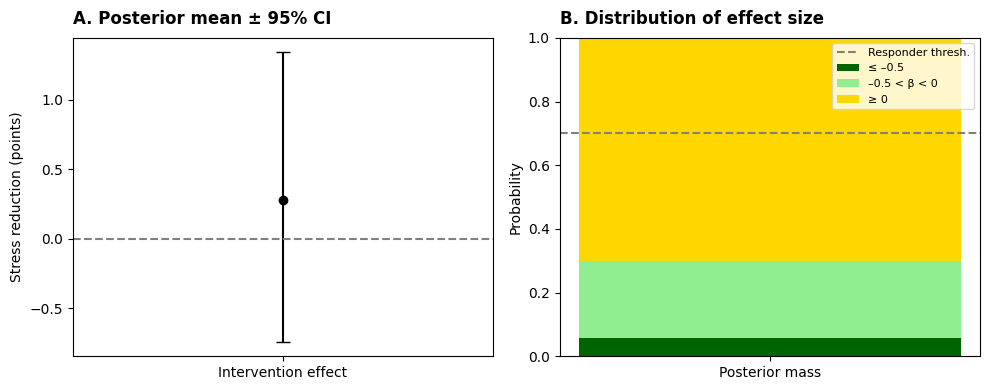

Model: Only fac1


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 543 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.110  0.345    -0.547      0.767      0.013    0.010     747.0   
rho      -0.073  0.222    -0.523      0.361      0.010    0.010     503.0   
sigma     1.124  0.157     0.839      1.412      0.007    0.007     632.0   
beta_f1   0.625  0.151     0.321      0.912      0.008    0.007     356.0   

          ess_tail  r_hat  
beta_int     566.0   1.00  
rho          390.0   1.01  
sigma        565.0   1.00  
beta_f1      380.0   1.01  
P(intervention reduces stress by ≥ 0.5 points) = 3.70%
P(beta_int ≤ –0.5) = 3.70%
P(–0.5 < beta_int < 0) = 34.40%
P(beta_int ≥ 0) = 61.90%


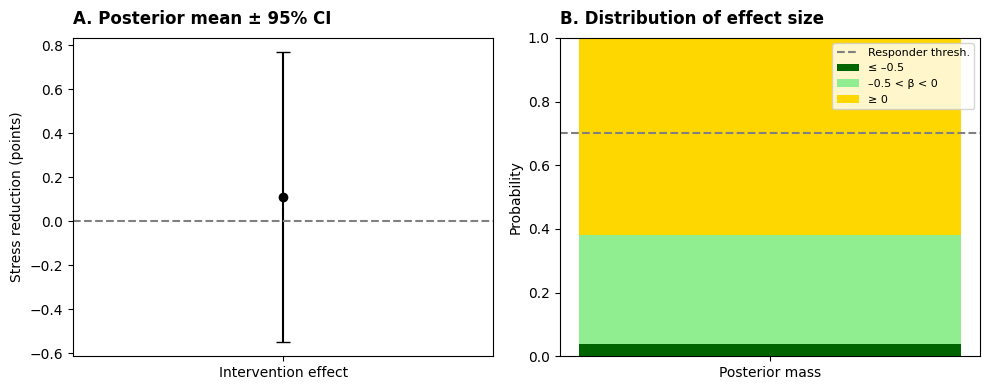

Model: Only fac2


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f2, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 431 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.202  0.494    -0.722      1.245      0.020    0.025     634.0   
rho       0.249  0.224    -0.170      0.684      0.010    0.008     471.0   
sigma     1.254  0.164     0.965      1.578      0.007    0.005     630.0   
beta_f2   0.373  0.169     0.025      0.679      0.009    0.006     353.0   

          ess_tail  r_hat  
beta_int     298.0    1.0  
rho          455.0    1.0  
sigma        624.0    1.0  
beta_f2      468.0    1.0  
P(intervention reduces stress by ≥ 0.5 points) = 7.20%
P(beta_int ≤ –0.5) = 7.20%
P(–0.5 < beta_int < 0) = 26.90%
P(beta_int ≥ 0) = 65.90%


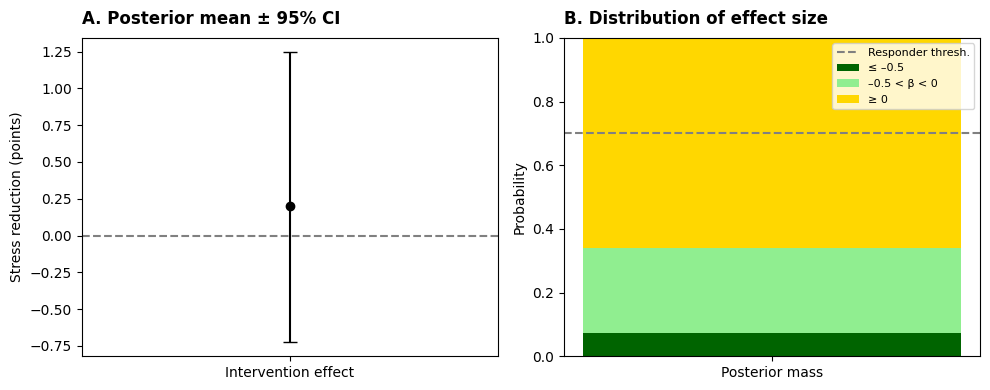

Model: Both fac1 and fac2


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, beta_f2, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 847 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.117  0.388    -0.606      0.831      0.015    0.024     672.0   
rho      -0.024  0.228    -0.475      0.408      0.010    0.010     491.0   
sigma     1.155  0.163     0.874      1.477      0.007    0.006     549.0   
beta_f1   0.522  0.206     0.158      0.946      0.009    0.007     502.0   
beta_f2   0.100  0.180    -0.223      0.489      0.008    0.007     491.0   

          ess_tail  r_hat  
beta_int     544.0    1.0  
rho          423.0    1.0  
sigma        578.0    1.0  
beta_f1      596.0    1.0  
beta_f2      483.0    1.0  
P(intervention reduces stress by ≥ 0.5 points) = 4.90%
P(beta_int ≤ –0.5) = 4.90%
P(–0.5 < beta_int < 0) = 33.00%
P(beta_int ≥ 0) = 62.10%


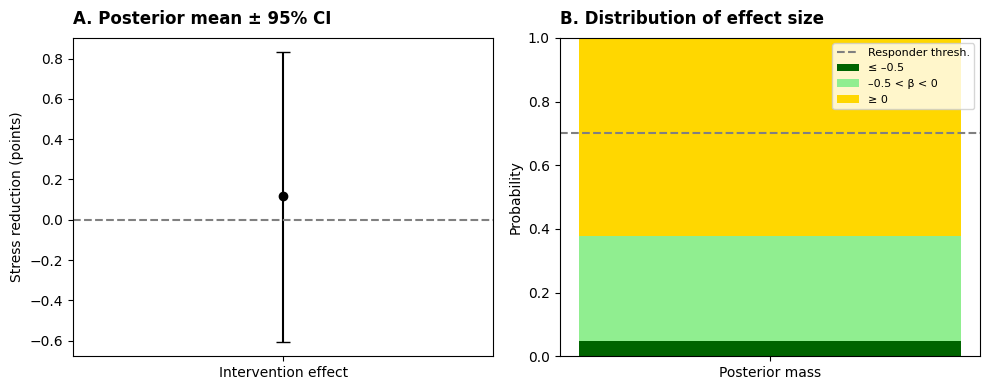

In [30]:
def run_ar1_model(include_fac1=False, include_fac2=False):
    outcome_data = df_mea[df_mea['measurement_name'] == 'Outcome']
    mediator_data = df_mea[df_mea['measurement_name'] == 'Mediators']

    merge_cols = ['current_day_of_study', 'survey1_question1_response', 'current_intervention_name']
    mediator_cols = []
    if include_fac1:
        mediator_cols.append('survey2_question1_response')
    if include_fac2:
        mediator_cols.append('survey2_question2_response')

    data = pd.merge(
        outcome_data[merge_cols],
        mediator_data[['current_day_of_study'] + mediator_cols] if mediator_cols else outcome_data[['current_day_of_study']],
        on='current_day_of_study',
        how='inner'
    ).dropna().sort_values('current_day_of_study').reset_index(drop=True)

    y = data['survey1_question1_response'].values
    interv = (data['current_intervention_name'] == "Listening to motivational podcasts!").astype(int).values
    n = len(y)
    fac1 = data['survey2_question1_response'].values if include_fac1 else None
    fac2 = data['survey2_question2_response'].values if include_fac2 else None

    with pm.Model() as model:
        beta0    = pm.Normal('beta0',    mu=0, sigma=10)
        beta_int = pm.Normal('beta_int', mu=0, sigma=1)
        if include_fac1:
            beta_f1 = pm.Normal('beta_f1', mu=0, sigma=10)
        if include_fac2:
            beta_f2 = pm.Normal('beta_f2', mu=0, sigma=10)
        rho      = pm.Uniform('rho',     lower=-1, upper=1)
        sigma    = pm.HalfNormal('sigma', sigma=1)

        mu = beta0 + beta_int * interv
        if include_fac1:
            mu = mu + beta_f1 * fac1
        if include_fac2:
            mu = mu + beta_f2 * fac2

        y_tt = pt.constant(y)

        def ar1_step(y_prev, mu_prev, mu_curr, rho):
            return mu_curr + rho * (y_prev - mu_prev)

        y_pred_scan, _ = scan(
            fn=ar1_step,
            sequences=[y_tt[:-1], mu[:-1], mu[1:]],
            non_sequences=[rho],
            n_steps=n-1,
            name="ar1_scan"
        )

        y_pred = pt.concatenate([[mu[0]], y_pred_scan], axis=0)
        pm.Normal('y_obs', mu=y_pred, sigma=sigma, observed=y_tt)

        trace = pm.sample(
            draws=500,
            tune=500,
            chains=2,
            target_accept=0.9,
            return_inferencedata=True
        )

    var_names = ['beta_int', 'rho', 'sigma']
    if include_fac1:
        var_names.append('beta_f1')
    if include_fac2:
        var_names.append('beta_f2')
    summary = az.summary(trace, var_names=var_names, hdi_prob=0.95)
    print(summary)

    prob_responder = (trace.posterior['beta_int'] < -0.5).mean().item()
    print(f"P(intervention reduces stress by ≥ 0.5 points) = {prob_responder:.2%}")

    beta_samples = trace.posterior['beta_int'].values.flatten()
    p_le_neg05 = (beta_samples <= -0.5).mean()
    p_between  = ((beta_samples > -0.5) & (beta_samples < 0)).mean()
    p_ge0      = (beta_samples >= 0).mean()

    print(f"P(beta_int ≤ –0.5) = {p_le_neg05:.2%}")
    print(f"P(–0.5 < beta_int < 0) = {p_between:.2%}")
    print(f"P(beta_int ≥ 0) = {p_ge0:.2%}")

    mean_beta = summary.loc['beta_int', 'mean']
    hdi_low   = summary.loc['beta_int', 'hdi_2.5%']
    hdi_high  = summary.loc['beta_int', 'hdi_97.5%']

    fig, axes = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [1, 1]})

    ax = axes[0]
    ax.errorbar(0, mean_beta,
                yerr=[[mean_beta - hdi_low], [hdi_high - mean_beta]],
                fmt='o', capsize=5, color='black')
    ax.axhline(0, color='gray', linestyle='--')
    ax.set_xticks([0])
    ax.set_xticklabels(["Intervention effect"])
    ax.set_ylabel('Stress reduction (points)')
    ax.set_title('A. Posterior mean ± 95% CI', loc='left', pad=10, fontsize=12, fontweight='bold')

    ax = axes[1]
    ax.bar(0, p_le_neg05,    width=0.6, color='darkgreen',  label='≤ –0.5')
    ax.bar(0, p_between,     width=0.6, bottom=p_le_neg05, color='lightgreen', label='–0.5 < β < 0')
    ax.bar(0, p_ge0,         width=0.6, bottom=p_le_neg05+p_between, color='gold', label='≥ 0')
    ax.axhline(0.7, color='gray', linestyle='--', label='Responder thresh.')
    ax.set_xticks([0])
    ax.set_xticklabels(['Posterior mass'])
    ax.set_ylim(0, 1)
    ax.set_ylabel('Probability')
    ax.set_title('B. Distribution of effect size', loc='left', pad=10, fontsize=12, fontweight='bold')
    ax.legend(loc='upper right', fontsize=8)

    plt.tight_layout()
    plt.show()

print("Model: Neither fac1 nor fac2 (intervention only)")
run_ar1_model(include_fac1=False, include_fac2=False)

print("Model: Only fac1")
run_ar1_model(include_fac1=True, include_fac2=False)

print("Model: Only fac2")
run_ar1_model(include_fac1=False, include_fac2=True)

print("Model: Both fac1 and fac2")
run_ar1_model(include_fac1=True, include_fac2=True)

####  Bayesian AR(1) Regression with Data-Driven Scale (MAD-Based)

Model: Only intervention


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 179 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.468  0.627    -0.603      1.809      0.030    0.021     429.0   
rho       0.496  0.214     0.154      0.958      0.011    0.007     407.0   
sigma     1.410  0.194     1.054      1.776      0.010    0.007     404.0   

          ess_tail  r_hat  
beta_int     396.0   1.00  
rho          263.0   1.01  
sigma        513.0   1.01  
P(intervention reduces stress by ≥ 0.5 points) = 5.00%
P(beta_int ≤ –0.5) = 5.00%
P(–0.5 < beta_int < 0) = 18.00%
P(beta_int ≥ 0) = 77.00%


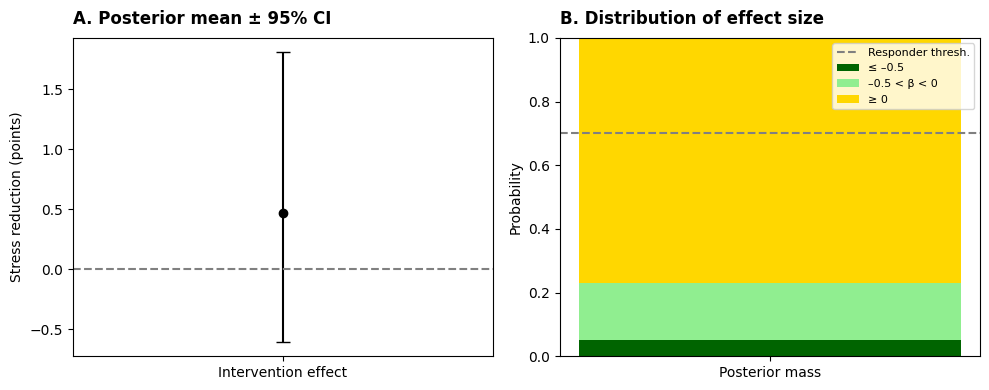


Model: Intervention + fac1


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 538 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.179  0.427    -0.719      1.018      0.024    0.025     338.0   
rho      -0.101  0.216    -0.488      0.336      0.011    0.008     433.0   
sigma     1.156  0.173     0.875      1.510      0.007    0.007     525.0   
beta_f1   0.681  0.140     0.381      0.949      0.007    0.007     443.0   

          ess_tail  r_hat  
beta_int     273.0   1.01  
rho          424.0   1.00  
sigma        572.0   1.00  
beta_f1      269.0   1.00  
P(intervention reduces stress by ≥ 0.5 points) = 4.30%
P(beta_int ≤ –0.5) = 4.30%
P(–0.5 < beta_int < 0) = 27.90%
P(beta_int ≥ 0) = 67.80%


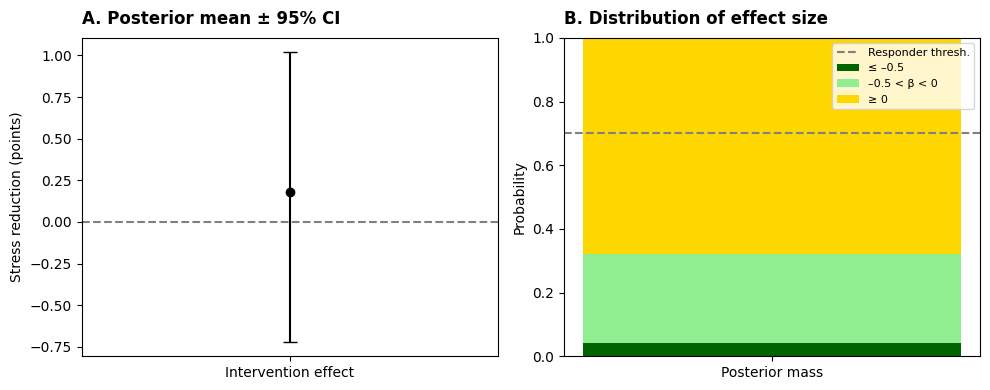


Model: Intervention + fac2


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f2, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 429 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.253  0.537    -0.719      1.351      0.020    0.015     743.0   
rho       0.203  0.229    -0.244      0.631      0.012    0.010     359.0   
sigma     1.301  0.187     0.954      1.648      0.008    0.008     535.0   
beta_f2   0.474  0.157     0.171      0.767      0.009    0.004     319.0   

          ess_tail  r_hat  
beta_int     698.0   1.00  
rho          396.0   1.01  
sigma        396.0   1.00  
beta_f2      623.0   1.01  
P(intervention reduces stress by ≥ 0.5 points) = 8.30%
P(beta_int ≤ –0.5) = 8.30%
P(–0.5 < beta_int < 0) = 23.50%
P(beta_int ≥ 0) = 68.20%


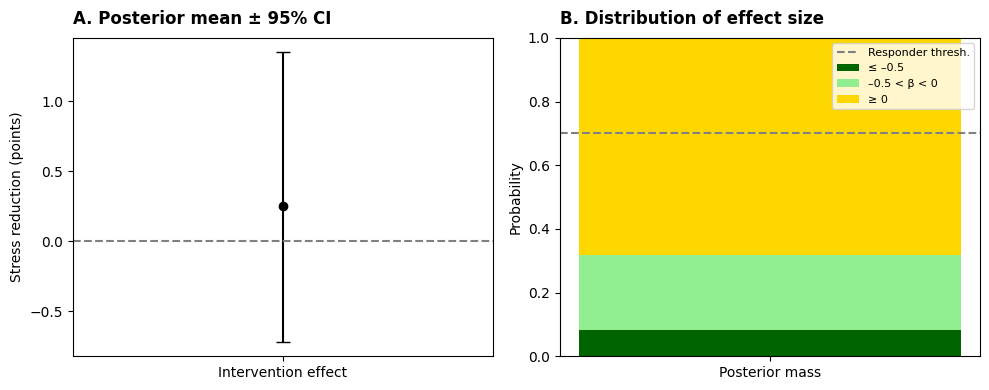


Model: Intervention + fac1 + fac2


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, beta_f2, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 658 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.147  0.396    -0.693      0.863      0.015    0.016     729.0   
rho      -0.093  0.210    -0.543      0.298      0.010    0.008     427.0   
sigma     1.166  0.167     0.879      1.506      0.008    0.006     448.0   
beta_f1   0.599  0.214     0.184      1.006      0.010    0.008     424.0   
beta_f2   0.110  0.200    -0.296      0.511      0.009    0.008     499.0   

          ess_tail  r_hat  
beta_int     456.0   1.00  
rho          517.0   1.00  
sigma        554.0   1.00  
beta_f1      564.0   1.01  
beta_f2      543.0   1.00  
P(intervention reduces stress by ≥ 0.5 points) = 4.30%
P(beta_int ≤ –0.5) = 4.30%
P(–0.5 < beta_int < 0) = 31.20%
P(beta_int ≥ 0) = 64.50%


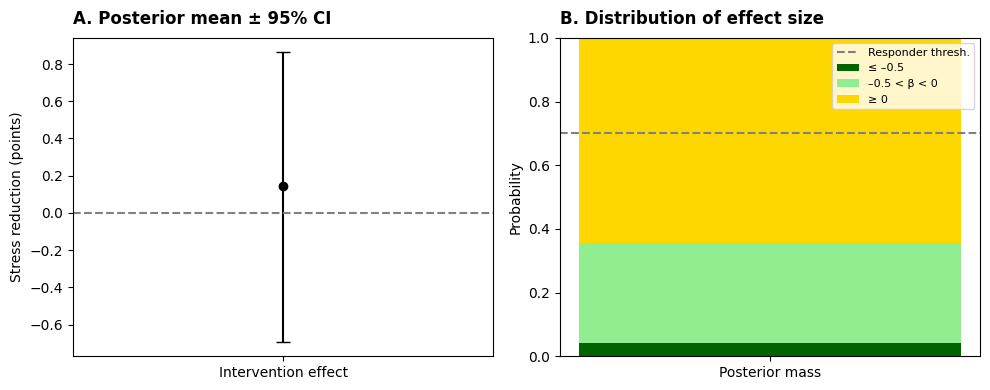

In [31]:
def run_ar1_model_data_driven_scale(include_fac1=False, include_fac2=False):
    outcome_data = df_mea[df_mea['measurement_name'] == 'Outcome']
    mediator_data = df_mea[df_mea['measurement_name'] == 'Mediators']

    merge_cols = ['current_day_of_study', 'survey1_question1_response', 'current_intervention_name']
    mediator_cols = []
    if include_fac1:
        mediator_cols.append('survey2_question1_response')
    if include_fac2:
        mediator_cols.append('survey2_question2_response')

    data = pd.merge(
        outcome_data[merge_cols],
        mediator_data[['current_day_of_study'] + mediator_cols] if mediator_cols else outcome_data[['current_day_of_study']],
        on='current_day_of_study',
        how='inner'
    ).dropna().sort_values('current_day_of_study').reset_index(drop=True)

    y = data['survey1_question1_response'].values
    interv = (data['current_intervention_name'] == "Listening to motivational podcasts!").astype(int).values
    n = len(y)
    fac1 = data['survey2_question1_response'].values if include_fac1 else None
    fac2 = data['survey2_question2_response'].values if include_fac2 else None

    mad = np.median(np.abs(y - np.median(y)))
    scale = max(mad, 2.0)

    with pm.Model() as model:
        beta0    = pm.StudentT('beta0',    nu=3, mu=0, sigma=scale)
        beta_int = pm.StudentT('beta_int', nu=3, mu=0, sigma=scale)
        if include_fac1:
            beta_f1 = pm.StudentT('beta_f1', nu=3, mu=0, sigma=scale)
        if include_fac2:
            beta_f2 = pm.StudentT('beta_f2', nu=3, mu=0, sigma=scale)
        rho      = pm.Uniform('rho',     lower=-1, upper=1)
        sigma    = pm.HalfStudentT('sigma', nu=3, sigma=scale)

        mu = beta0 + beta_int * interv
        if include_fac1:
            mu = mu + beta_f1 * fac1
        if include_fac2:
            mu = mu + beta_f2 * fac2

        y_tt = pt.constant(y)

        def ar1_step(y_prev, mu_prev, mu_curr, rho):
            return mu_curr + rho * (y_prev - mu_prev)

        y_pred_scan, _ = scan(
            fn=ar1_step,
            sequences=[y_tt[:-1], mu[:-1], mu[1:]],
            non_sequences=[rho],
            n_steps=n-1,
            name="ar1_scan"
        )

        y_pred = pt.concatenate([[mu[0]], y_pred_scan], axis=0)
        pm.Normal('y_obs', mu=y_pred, sigma=sigma, observed=y_tt)

        trace = pm.sample(
            draws=500,
            tune=500,
            chains=2,
            target_accept=0.9,
            return_inferencedata=True
        )

    var_names = ['beta_int', 'rho', 'sigma']
    if include_fac1:
        var_names.append('beta_f1')
    if include_fac2:
        var_names.append('beta_f2')
    summary = az.summary(trace, var_names=var_names, hdi_prob=0.95)
    print(summary)

    prob_responder = (trace.posterior['beta_int'] < -0.5).mean().item()
    print(f"P(intervention reduces stress by ≥ 0.5 points) = {prob_responder:.2%}")

    beta_samples = trace.posterior['beta_int'].values.flatten()
    p_le_neg05 = (beta_samples <= -0.5).mean()
    p_between  = ((beta_samples > -0.5) & (beta_samples < 0)).mean()
    p_ge0      = (beta_samples >= 0).mean()

    print(f"P(beta_int ≤ –0.5) = {p_le_neg05:.2%}")
    print(f"P(–0.5 < beta_int < 0) = {p_between:.2%}")
    print(f"P(beta_int ≥ 0) = {p_ge0:.2%}")

    mean_beta = summary.loc['beta_int', 'mean']
    hdi_low   = summary.loc['beta_int', 'hdi_2.5%']
    hdi_high  = summary.loc['beta_int', 'hdi_97.5%']

    fig, axes = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [1, 1]})

    ax = axes[0]
    ax.errorbar(0, mean_beta,
                yerr=[[mean_beta - hdi_low], [hdi_high - mean_beta]],
                fmt='o', capsize=5, color='black')
    ax.axhline(0, color='gray', linestyle='--')
    ax.set_xticks([0])
    ax.set_xticklabels(["Intervention effect"])
    ax.set_ylabel('Stress reduction (points)')
    ax.set_title('A. Posterior mean ± 95% CI', loc='left', pad=10, fontsize=12, fontweight='bold')

    ax = axes[1]
    ax.bar(0, p_le_neg05,    width=0.6, color='darkgreen',  label='≤ –0.5')
    ax.bar(0, p_between,     width=0.6, bottom=p_le_neg05, color='lightgreen', label='–0.5 < β < 0')
    ax.bar(0, p_ge0,         width=0.6, bottom=p_le_neg05+p_between, color='gold', label='≥ 0')
    ax.axhline(0.7, color='gray', linestyle='--', label='Responder thresh.')
    ax.set_xticks([0])
    ax.set_xticklabels(['Posterior mass'])
    ax.set_ylim(0, 1)
    ax.set_ylabel('Probability')
    ax.set_title('B. Distribution of effect size', loc='left', pad=10, fontsize=12, fontweight='bold')
    ax.legend(loc='upper right', fontsize=8)

    plt.tight_layout()
    plt.show()

print("Model: Only intervention")
run_ar1_model_data_driven_scale(include_fac1=False, include_fac2=False)

print("\nModel: Intervention + fac1")
run_ar1_model_data_driven_scale(include_fac1=True, include_fac2=False)

print("\nModel: Intervention + fac2")
run_ar1_model_data_driven_scale(include_fac1=False, include_fac2=True)

print("\nModel: Intervention + fac1 + fac2")
run_ar1_model_data_driven_scale(include_fac1=True, include_fac2=True)

#### Bayesian AR(1) Regression with Consecutive‐Day Adjustment

Only intervention:


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\pymc\model\core.py:1300: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, rho, sigma, y_obs_unobserved]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 147 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.185  0.518    -0.803      1.243      0.017    0.015     890.0   
rho       0.370  0.192     0.008      0.750      0.007    0.006     803.0   
sigma     1.392  0.192     1.020      1.745      0.006    0.007     929.0   

          ess_tail  r_hat  
beta_int     713.0    1.0  
rho          450.0    1.0  
sigma        724.0    1.0  
P(intervention reduces stress by ≥ 0.5 points) = 9.40%
P(beta_int ≤ –0.5) = 9.40%
P(–0.5 < beta_int < 0) = 26.30%
P(beta_int ≥ 0) = 64.30%


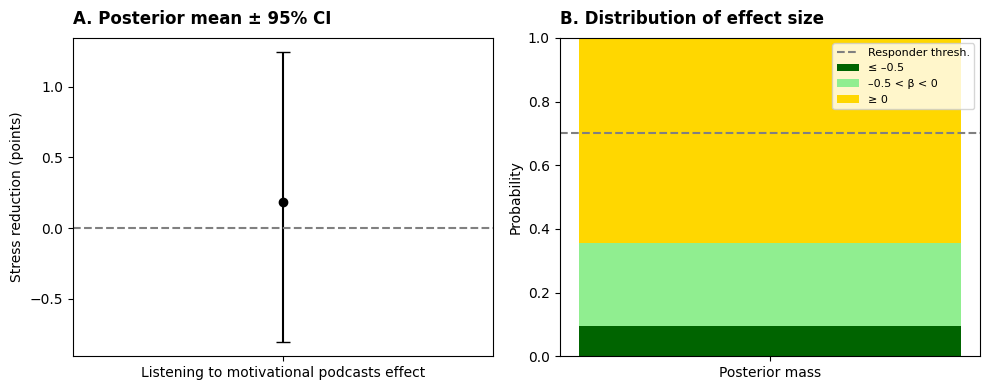


Intervention + fac1:


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\pymc\model\core.py:1300: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, rho, sigma, y_obs_unobserved]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 438 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.156  0.429    -0.655      1.070      0.015    0.016     799.0   
rho       0.124  0.232    -0.357      0.548      0.012    0.009     417.0   
sigma     1.143  0.158     0.867      1.464      0.007    0.005     543.0   
beta_f1   0.569  0.143     0.308      0.864      0.007    0.005     396.0   

          ess_tail  r_hat  
beta_int     447.0   1.00  
rho          331.0   1.02  
sigma        593.0   1.00  
beta_f1      556.0   1.00  
P(intervention reduces stress by ≥ 0.5 points) = 6.20%
P(beta_int ≤ –0.5) = 6.20%
P(–0.5 < beta_int < 0) = 29.50%
P(beta_int ≥ 0) = 64.30%


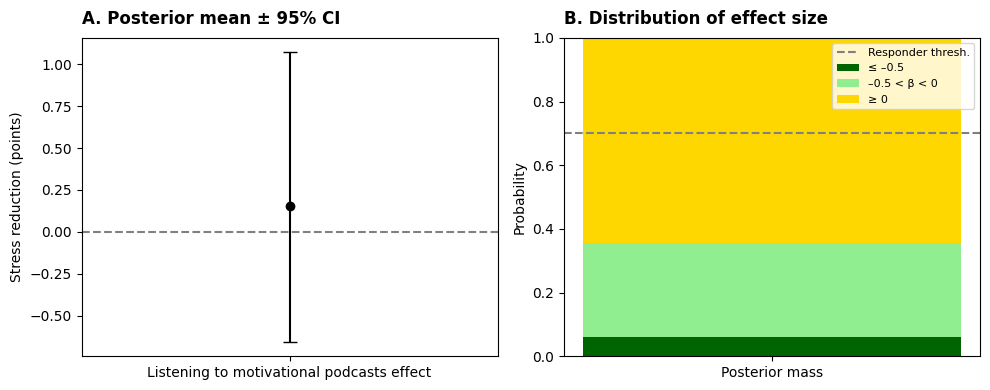


Intervention + fac2:


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\pymc\model\core.py:1300: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f2, rho, sigma, y_obs_unobserved]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 471 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.099  0.427    -0.686      1.009      0.015    0.013     838.0   
rho       0.197  0.201    -0.187      0.609      0.008    0.008     706.0   
sigma     1.253  0.171     0.943      1.597      0.007    0.005     617.0   
beta_f2   0.426  0.148     0.124      0.697      0.008    0.005     387.0   

          ess_tail  r_hat  
beta_int     672.0   1.00  
rho          514.0   1.00  
sigma        723.0   1.00  
beta_f2      434.0   1.01  
P(intervention reduces stress by ≥ 0.5 points) = 8.10%
P(beta_int ≤ –0.5) = 8.10%
P(–0.5 < beta_int < 0) = 31.60%
P(beta_int ≥ 0) = 60.30%


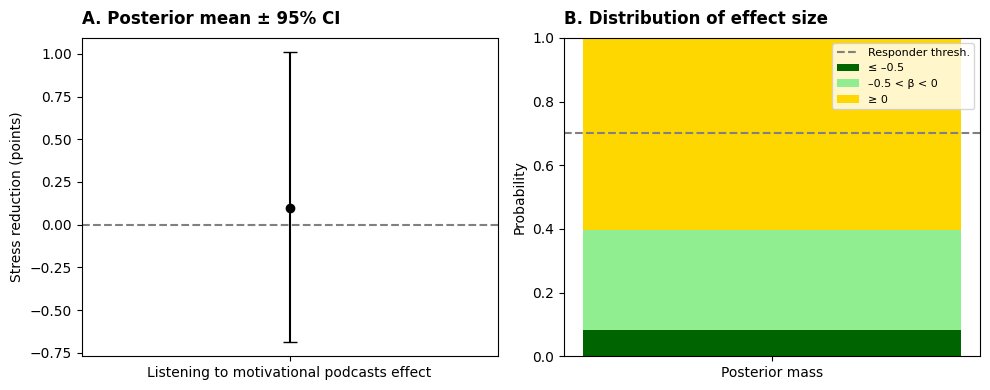


Intervention + fac1 + fac2:


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\pymc\model\core.py:1300: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, beta_f2, rho, sigma, y_obs_unobserved]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 789 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.131  0.406    -0.637      0.946      0.014    0.012     875.0   
rho       0.085  0.222    -0.415      0.518      0.010    0.010     499.0   
sigma     1.157  0.160     0.892      1.485      0.008    0.007     453.0   
beta_f1   0.509  0.206     0.112      0.903      0.014    0.007     239.0   
beta_f2   0.090  0.200    -0.330      0.437      0.011    0.007     361.0   

          ess_tail  r_hat  
beta_int     555.0   1.00  
rho          501.0   1.00  
sigma        489.0   1.00  
beta_f1      518.0   1.01  
beta_f2      457.0   1.01  
P(intervention reduces stress by ≥ 0.5 points) = 5.30%
P(beta_int ≤ –0.5) = 5.30%
P(–0.5 < beta_int < 0) = 32.00%
P(beta_int ≥ 0) = 62.70%


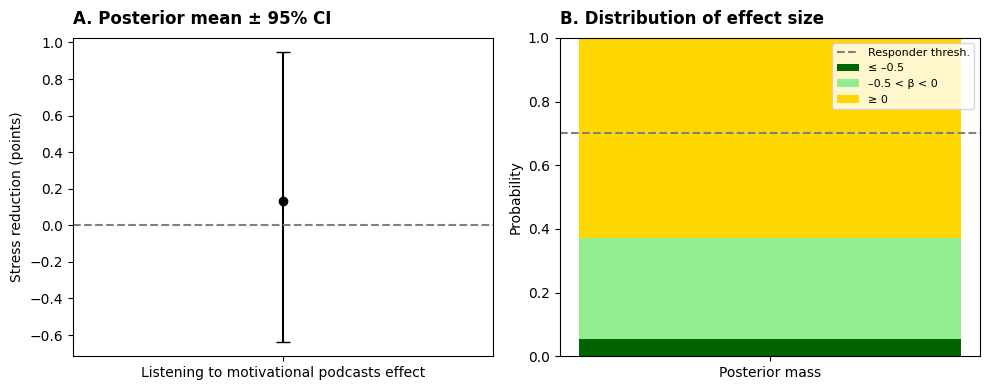

(Inference data with groups:
 	> posterior
 	> sample_stats
 	> observed_data,
            mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
 beta_int  0.131  0.406    -0.637      0.946      0.014    0.012     875.0   
 rho       0.085  0.222    -0.415      0.518      0.010    0.010     499.0   
 sigma     1.157  0.160     0.892      1.485      0.008    0.007     453.0   
 beta_f1   0.509  0.206     0.112      0.903      0.014    0.007     239.0   
 beta_f2   0.090  0.200    -0.330      0.437      0.011    0.007     361.0   
 
           ess_tail  r_hat  
 beta_int     555.0   1.00  
 rho          501.0   1.00  
 sigma        489.0   1.00  
 beta_f1      518.0   1.01  
 beta_f2      457.0   1.01  )

In [21]:
def run_ar1_model(df_mea, use_fac1=False, use_fac2=False):
    days_full = pd.DataFrame({'current_day_of_study': np.arange(0, 32)})

    outcome_data = df_mea[df_mea['measurement_name'] == 'Outcome'][
        ['current_day_of_study',
         'survey1_question1_response',   
         'current_intervention_name']
    ]
    mediator_data = df_mea[df_mea['measurement_name'] == 'Mediators'][
        ['current_day_of_study',
         'survey2_question1_response',   
         'survey2_question2_response']   
    ]

    data = (
        days_full
        .merge(outcome_data,  on='current_day_of_study', how='left')
        .merge(mediator_data, on='current_day_of_study', how='left')
        .sort_values('current_day_of_study')
        .reset_index(drop=True)
    )

    days   = data['current_day_of_study'].values
    y      = data['survey1_question1_response'].values.astype(float)  
    n      = len(y)  

    interv = (data['current_intervention_name'] == "Listening to motivational podcasts!").astype(float).fillna(0).values

    if use_fac1:
        fac1 = data['survey2_question1_response'].values.astype(float)
        fac1 = np.nan_to_num(fac1, nan=0.0)
    else:
        fac1 = np.zeros_like(days, dtype=float)

    if use_fac2:
        fac2 = data['survey2_question2_response'].values.astype(float)
        fac2 = np.nan_to_num(fac2, nan=0.0)
    else:
        fac2 = np.zeros_like(days, dtype=float)

    obs_mask = ~np.isnan(y)
    consec   = np.zeros(n, dtype=float)
    consec[1:] = (obs_mask[1:] & obs_mask[:-1]).astype(float)

    with pm.Model() as model:
        beta0    = pm.Normal('beta0',    mu=0, sigma=10)
        beta_int = pm.Normal('beta_int', mu=0, sigma=1)
        if use_fac1:
            beta_f1  = pm.Normal('beta_f1',  mu=0, sigma=10)
        if use_fac2:
            beta_f2  = pm.Normal('beta_f2',  mu=0, sigma=10)
        rho      = pm.Uniform('rho',     lower=-1, upper=1)
        sigma    = pm.HalfNormal('sigma', sigma=1)

        mu = beta0 + beta_int * interv
        if use_fac1:
            mu = mu + beta_f1 * fac1
        if use_fac2:
            mu = mu + beta_f2 * fac2

        y_tt      = pt.constant(y)            
        mu_tt     = mu
        consec_tt = pt.constant(consec)

        def ar1_step(y_prev, mu_prev, mu_curr, consec_prev, rho):
            ar_term = pt.switch(pt.eq(consec_prev, 1.0), rho * (y_prev - mu_prev), 0.0)
            return mu_curr + ar_term

        y_pred_scan, _ = scan(
            fn=ar1_step,
            sequences=[y_tt[:-1], mu_tt[:-1], mu_tt[1:], consec_tt[:-1]],
            non_sequences=[rho],
            n_steps=n-1,
            name="ar1_scan"
        )

        y_pred = pt.concatenate([[mu_tt[0]], y_pred_scan], axis=0)

        y_obs_masked = np.ma.masked_invalid(y)
        pm.Normal('y_obs', mu=y_pred, sigma=sigma, observed=y_obs_masked)

        trace = pm.sample(
            draws=500,
            tune=500,
            chains=2,
            target_accept=0.9,
            return_inferencedata=True
        )

    var_names = ['beta_int', 'rho', 'sigma']
    if use_fac1:
        var_names.append('beta_f1')
    if use_fac2:
        var_names.append('beta_f2')

    summary = az.summary(trace, var_names=var_names, hdi_prob=0.95)
    print(summary)

    prob_responder = (trace.posterior['beta_int'] < -0.5).mean().item()
    print(f"P(intervention reduces stress by ≥ 0.5 points) = {prob_responder:.2%}")

    beta_samples = trace.posterior['beta_int'].values.flatten()
    p_le_neg05 = (beta_samples <= -0.5).mean()
    p_between  = ((beta_samples > -0.5) & (beta_samples < 0)).mean()
    p_ge0      = (beta_samples >= 0).mean()

    print(f"P(beta_int ≤ –0.5) = {p_le_neg05:.2%}")
    print(f"P(–0.5 < beta_int < 0) = {p_between:.2%}")
    print(f"P(beta_int ≥ 0) = {p_ge0:.2%}")

    mean_beta = summary.loc['beta_int', 'mean']
    hdi_low   = summary.loc['beta_int', 'hdi_2.5%']
    hdi_high  = summary.loc['beta_int', 'hdi_97.5%']

    fig, axes = plt.subplots(1, 2, figsize=(10, 4),
                             gridspec_kw={'width_ratios': [1, 1]})

    ax = axes[0]
    ax.errorbar(0, mean_beta,
                yerr=[[mean_beta - hdi_low], [hdi_high - mean_beta]],
                fmt='o', capsize=5, color='black')
    ax.axhline(0, color='gray', linestyle='--')
    ax.set_xticks([0])
    ax.set_xticklabels(["Listening to motivational podcasts effect"])
    ax.set_ylabel('Stress reduction (points)')
    ax.set_title('A. Posterior mean ± 95% CI', loc='left',
                 pad=10, fontsize=12, fontweight='bold')

    ax = axes[1]
    ax.bar(0, p_le_neg05,    width=0.6, color='darkgreen',  label='≤ –0.5')
    ax.bar(0, p_between,     width=0.6, bottom=p_le_neg05, color='lightgreen', label='–0.5 < β < 0')
    ax.bar(0, p_ge0,         width=0.6, bottom=p_le_neg05+p_between, color='gold',       label='≥ 0')
    ax.axhline(0.7, color='gray', linestyle='--', label='Responder thresh.')
    ax.set_xticks([0])
    ax.set_xticklabels(['Posterior mass'])
    ax.set_ylim(0, 1)
    ax.set_ylabel('Probability')
    ax.set_title('B. Distribution of effect size', loc='left',
                 pad=10, fontsize=12, fontweight='bold')
    ax.legend(loc='upper right', fontsize=8)

    plt.tight_layout()
    plt.show()

    return trace, summary

print("Only intervention:")
run_ar1_model(df_mea, use_fac1=False, use_fac2=False)

print("\nIntervention + fac1:")
run_ar1_model(df_mea, use_fac1=True, use_fac2=False)

print("\nIntervention + fac2:")
run_ar1_model(df_mea, use_fac1=False, use_fac2=True)

print("\nIntervention + fac1 + fac2:")
run_ar1_model(df_mea, use_fac1=True, use_fac2=True)


#### Bayesian AR(1) Model of Daily Stress Response to listening to motivational podcasts and Mediators - Mean Imputation Method

In [22]:
imputed_data_o = df_mea[df_mea['measurement_name'] == 'Outcome'].copy()
imputed_data_o['current_day_of_study'] = imputed_data_o['current_day_of_study'].astype(int)

imputed_data_m = df_mea[df_mea['measurement_name'] == 'Mediators'].copy()
imputed_data_m['current_day_of_study'] = imputed_data_m['current_day_of_study'].astype(int)

days = pd.DataFrame({'current_day_of_study': range(0, 32)})

imputed_complete_o = days.merge(
    imputed_data_o, 
    how='left', 
    on='current_day_of_study'
)

imputed_complete_o['measurement_name'].fillna('Outcome', inplace=True)

imputed_complete_m = days.merge(
    imputed_data_m, 
    how='left', 
    on='current_day_of_study'
)

imputed_complete_m['measurement_name'].fillna('Mediators', inplace=True)

C:\Users\USER\AppData\Local\Temp\ipykernel_9052\1570007407.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  imputed_complete_o['measurement_name'].fillna('Outcome', inplace=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_9052\1570007407.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves

In [23]:
df_o = imputed_complete_o.copy()
df_m = imputed_complete_m.copy()
pattern = (
    ['A'] * 4 +
    ['B'] * 8 +
    ['A'] * 4 +
    ['B'] * 4 +
    ['A'] * 8 +
    ['B'] * 4
)
txt = {
    'A': "Listening to motivational podcasts!",
    'B': "Not listening to motivational podcasts!"
}


df_unique_o = (
    df_o
    .sort_values('current_day_of_study')       
    .groupby('current_day_of_study', as_index=True)
    .first()                                  
)

df_fill_o = (
    df_unique_o
    .reindex(range(0, 32))                     
    .reset_index()                             
)

mask_o = df_fill_o['current_intervention_name'].isna()
df_fill_o.loc[mask_o, 'current_intervention_name'] = (
    df_fill_o.loc[mask_o, 'current_day_of_study']
            .map(lambda day: txt[ pattern[int(day)] ])
)

df_unique_m = (
    df_m
    .sort_values('current_day_of_study')       
    .groupby('current_day_of_study', as_index=True)
    .first()                                  
)

df_fill_m = (
    df_unique_m
    .reindex(range(0, 32))                     
    .reset_index()                             
)

mask_m = df_fill_m['current_intervention_name'].isna()
df_fill_m.loc[mask_m, 'current_intervention_name'] = (
    df_fill_m.loc[mask_m, 'current_day_of_study']
            .map(lambda day: txt[ pattern[int(day)] ])
)

In [24]:
df_mean_imp_o = df_fill_o.copy()
df_mean_imp_m = df_fill_m.copy()
df_mean_imp_o['survey1_question1_response'] = (
    df_mean_imp_o
    .groupby('current_intervention_name')['survey1_question1_response']
    .transform(lambda grp: grp.fillna(grp.mean()))
)

cols_to_impute = [
    'survey2_question1_response',
    'survey2_question2_response'
]

for col in cols_to_impute:
    df_mean_imp_m[col] = (
        df_mean_imp_m
        .groupby('current_intervention_name')[col]
        .transform(lambda grp: grp.fillna(grp.mean()))
    )

Model: Neither fac1 nor fac2 (intervention only)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 117 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.401  0.523    -0.550      1.496      0.021    0.018     627.0   
rho       0.497  0.214     0.147      0.999      0.018    0.017     146.0   
sigma     1.334  0.172     1.031      1.667      0.006    0.006     786.0   

          ess_tail  r_hat  
beta_int     583.0   1.00  
rho           62.0   1.02  
sigma        613.0   1.01  
P(intervention reduces stress by ≥ 0.5 points) = 4.20%
P(beta_int ≤ –0.5) = 4.20%
P(–0.5 < beta_int < 0) = 17.70%
P(beta_int ≥ 0) = 78.10%


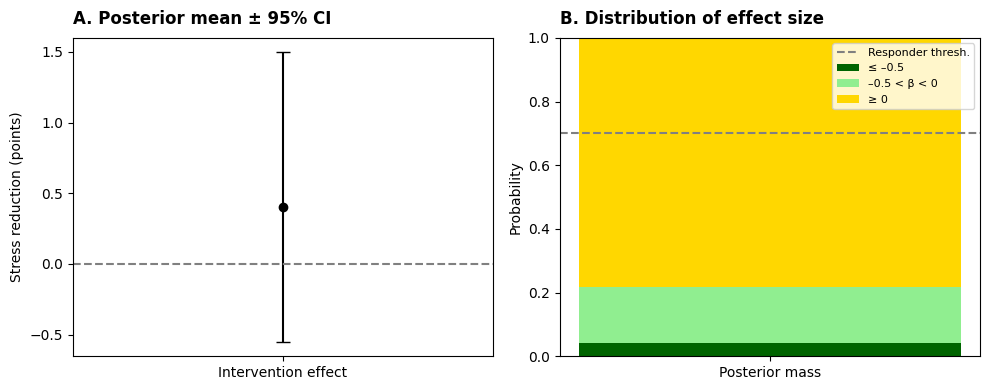

Model: Only fac1


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 465 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.158  0.406    -0.647      0.961      0.017    0.017     600.0   
rho       0.003  0.246    -0.519      0.476      0.013    0.013     365.0   
sigma     1.121  0.152     0.864      1.421      0.006    0.004     749.0   
beta_f1   0.595  0.160     0.265      0.867      0.008    0.006     369.0   

          ess_tail  r_hat  
beta_int     406.0   1.00  
rho          194.0   1.01  
sigma        730.0   1.00  
beta_f1      445.0   1.00  
P(intervention reduces stress by ≥ 0.5 points) = 5.10%
P(beta_int ≤ –0.5) = 5.10%
P(–0.5 < beta_int < 0) = 29.90%
P(beta_int ≥ 0) = 65.00%


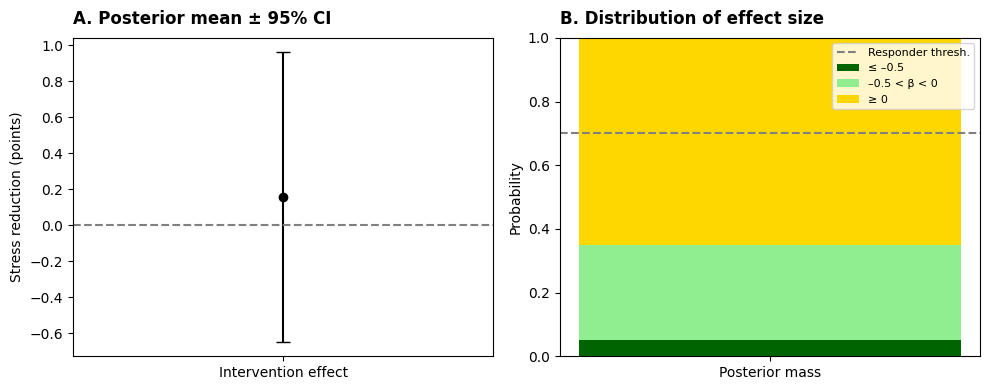

Model: Only fac2


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f2, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 300 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.192  0.477    -0.756      1.146      0.020    0.017     575.0   
rho       0.262  0.223    -0.137      0.753      0.012    0.008     360.0   
sigma     1.237  0.155     0.953      1.526      0.007    0.006     608.0   
beta_f2   0.358  0.166     0.047      0.697      0.009    0.006     344.0   

          ess_tail  r_hat  
beta_int     551.0    1.0  
rho          296.0    1.0  
sigma        520.0    1.0  
beta_f2      419.0    1.0  
P(intervention reduces stress by ≥ 0.5 points) = 6.30%
P(beta_int ≤ –0.5) = 6.30%
P(–0.5 < beta_int < 0) = 27.90%
P(beta_int ≥ 0) = 65.80%


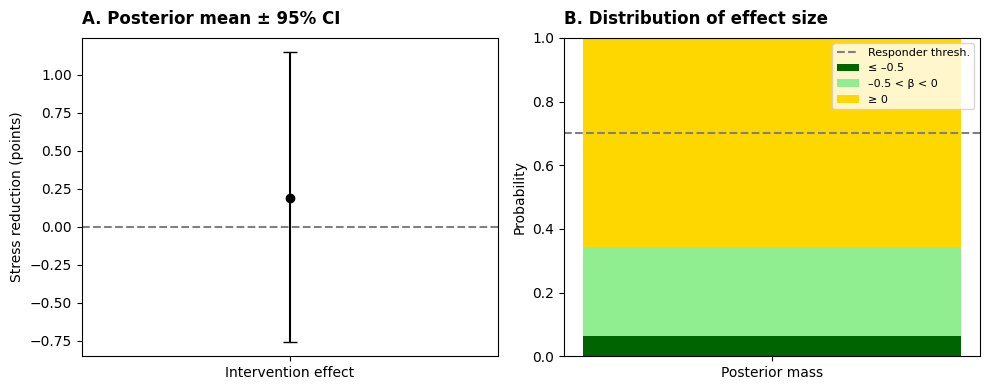

Model: Both fac1 and fac2


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, beta_f2, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 684 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.106  0.388    -0.693      0.839      0.015    0.014     647.0   
rho       0.012  0.234    -0.472      0.465      0.010    0.008     513.0   
sigma     1.133  0.145     0.893      1.454      0.006    0.005     681.0   
beta_f1   0.514  0.197     0.121      0.878      0.009    0.006     440.0   
beta_f2   0.096  0.180    -0.273      0.434      0.008    0.006     466.0   

          ess_tail  r_hat  
beta_int     689.0    1.0  
rho          504.0    1.0  
sigma        619.0    1.0  
beta_f1      477.0    1.0  
beta_f2      605.0    1.0  
P(intervention reduces stress by ≥ 0.5 points) = 6.60%
P(beta_int ≤ –0.5) = 6.60%
P(–0.5 < beta_int < 0) = 31.80%
P(beta_int ≥ 0) = 61.60%


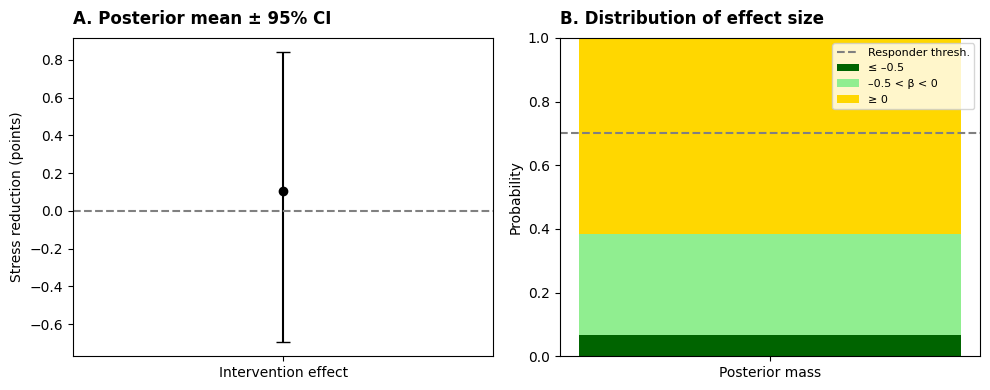

In [25]:
def run_ar1_model(include_fac1=False, include_fac2=False):
    outcome_data = df_mean_imp_o.copy()
    mediator_data = df_mean_imp_m.copy()

    merge_cols = ['current_day_of_study', 'survey1_question1_response', 'current_intervention_name']
    mediator_cols = []
    if include_fac1:
        mediator_cols.append('survey2_question1_response')
    if include_fac2:
        mediator_cols.append('survey2_question2_response')

    data = pd.merge(
        outcome_data[merge_cols],
        mediator_data[['current_day_of_study'] + mediator_cols] if mediator_cols else outcome_data[['current_day_of_study']],
        on='current_day_of_study',
        how='inner'
    ).dropna().sort_values('current_day_of_study').reset_index(drop=True)

    y = data['survey1_question1_response'].values
    interv = (data['current_intervention_name'] == "Listening to motivational podcasts!").astype(int).values
    n = len(y)
    fac1 = data['survey2_question1_response'].values if include_fac1 else None
    fac2 = data['survey2_question2_response'].values if include_fac2 else None

    with pm.Model() as model:
        beta0    = pm.Normal('beta0',    mu=0, sigma=10)
        beta_int = pm.Normal('beta_int', mu=0, sigma=1)
        if include_fac1:
            beta_f1 = pm.Normal('beta_f1', mu=0, sigma=10)
        if include_fac2:
            beta_f2 = pm.Normal('beta_f2', mu=0, sigma=10)
        rho      = pm.Uniform('rho',     lower=-1, upper=1)
        sigma    = pm.HalfNormal('sigma', sigma=1)

        mu = beta0 + beta_int * interv
        if include_fac1:
            mu = mu + beta_f1 * fac1
        if include_fac2:
            mu = mu + beta_f2 * fac2

        y_tt = pt.constant(y)

        def ar1_step(y_prev, mu_prev, mu_curr, rho):
            return mu_curr + rho * (y_prev - mu_prev)

        y_pred_scan, _ = scan(
            fn=ar1_step,
            sequences=[y_tt[:-1], mu[:-1], mu[1:]],
            non_sequences=[rho],
            n_steps=n-1,
            name="ar1_scan"
        )

        y_pred = pt.concatenate([[mu[0]], y_pred_scan], axis=0)
        pm.Normal('y_obs', mu=y_pred, sigma=sigma, observed=y_tt)

        trace = pm.sample(
            draws=500,
            tune=500,
            chains=2,
            target_accept=0.9,
            return_inferencedata=True
        )

    var_names = ['beta_int', 'rho', 'sigma']
    if include_fac1:
        var_names.append('beta_f1')
    if include_fac2:
        var_names.append('beta_f2')
    summary = az.summary(trace, var_names=var_names, hdi_prob=0.95)
    print(summary)

    prob_responder = (trace.posterior['beta_int'] < -0.5).mean().item()
    print(f"P(intervention reduces stress by ≥ 0.5 points) = {prob_responder:.2%}")

    beta_samples = trace.posterior['beta_int'].values.flatten()
    p_le_neg05 = (beta_samples <= -0.5).mean()
    p_between  = ((beta_samples > -0.5) & (beta_samples < 0)).mean()
    p_ge0      = (beta_samples >= 0).mean()

    print(f"P(beta_int ≤ –0.5) = {p_le_neg05:.2%}")
    print(f"P(–0.5 < beta_int < 0) = {p_between:.2%}")
    print(f"P(beta_int ≥ 0) = {p_ge0:.2%}")

    mean_beta = summary.loc['beta_int', 'mean']
    hdi_low   = summary.loc['beta_int', 'hdi_2.5%']
    hdi_high  = summary.loc['beta_int', 'hdi_97.5%']

    fig, axes = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [1, 1]})

    ax = axes[0]
    ax.errorbar(0, mean_beta,
                yerr=[[mean_beta - hdi_low], [hdi_high - mean_beta]],
                fmt='o', capsize=5, color='black')
    ax.axhline(0, color='gray', linestyle='--')
    ax.set_xticks([0])
    ax.set_xticklabels(["Intervention effect"])
    ax.set_ylabel('Stress reduction (points)')
    ax.set_title('A. Posterior mean ± 95% CI', loc='left', pad=10, fontsize=12, fontweight='bold')

    # Panel B
    ax = axes[1]
    ax.bar(0, p_le_neg05,    width=0.6, color='darkgreen',  label='≤ –0.5')
    ax.bar(0, p_between,     width=0.6, bottom=p_le_neg05, color='lightgreen', label='–0.5 < β < 0')
    ax.bar(0, p_ge0,         width=0.6, bottom=p_le_neg05+p_between, color='gold', label='≥ 0')
    ax.axhline(0.7, color='gray', linestyle='--', label='Responder thresh.')
    ax.set_xticks([0])
    ax.set_xticklabels(['Posterior mass'])
    ax.set_ylim(0, 1)
    ax.set_ylabel('Probability')
    ax.set_title('B. Distribution of effect size', loc='left', pad=10, fontsize=12, fontweight='bold')
    ax.legend(loc='upper right', fontsize=8)

    plt.tight_layout()
    plt.show()

print("Model: Neither fac1 nor fac2 (intervention only)")
run_ar1_model(include_fac1=False, include_fac2=False)

print("Model: Only fac1")
run_ar1_model(include_fac1=True, include_fac2=False)

print("Model: Only fac2")
run_ar1_model(include_fac1=False, include_fac2=True)

print("Model: Both fac1 and fac2")
run_ar1_model(include_fac1=True, include_fac2=True)

#### Bayesian AR(1) Model of Daily Stress Response to listening to motivational podcasts and Mediators - Latent Missing Method

In [26]:
def run_ar1_model(include_fac1=False, include_fac2=False):
    outcome_data = df_mea[df_mea['measurement_name'] == 'Outcome']
    mediator_data = df_mea[df_mea['measurement_name'] == 'Mediators']

    merge_cols = ['current_day_of_study', 'survey1_question1_response', 'current_intervention_name']
    mediator_cols = []
    if include_fac1:
        mediator_cols.append('survey2_question1_response')
    if include_fac2:
        mediator_cols.append('survey2_question2_response')

    all_days = pd.DataFrame({'current_day_of_study': np.arange(0, 32)})
    outcome_data = pd.merge(all_days, outcome_data[merge_cols], on='current_day_of_study', how='left')
    if mediator_cols:
        mediator_data = pd.merge(all_days,
                                  mediator_data[['current_day_of_study'] + mediator_cols],
                                  on='current_day_of_study', how='left')
    else:
        mediator_data = all_days.copy()

    data = (pd.merge(outcome_data, mediator_data, on='current_day_of_study', how='left')
              .sort_values('current_day_of_study')
              .reset_index(drop=True))

    y_obs_raw = data['survey1_question1_response'].values
    y_obs = y_obs_raw.astype(float)
    interv = (data['current_intervention_name'] == "Listening to motivational podcasts!").astype(float).fillna(0.0)
    fac1 = data['survey2_question1_response'].values if include_fac1 else None
    fac2 = data['survey2_question2_response'].values if include_fac2 else None
    n = len(y_obs)

    nan_idx = np.isnan(y_obs)
    obs_idx = ~nan_idx
    missing_idx = np.where(nan_idx)[0].tolist()

    with pm.Model() as model:
        beta0    = pm.Normal('beta0',    mu=0, sigma=10)
        beta_int = pm.Normal('beta_int', mu=0, sigma=1)
        if include_fac1:
            beta_f1 = pm.Normal('beta_f1', mu=0, sigma=10)
        if include_fac2:
            beta_f2 = pm.Normal('beta_f2', mu=0, sigma=10)
        rho   = pm.Uniform('rho', lower=-1, upper=1)
        sigma = pm.HalfNormal('sigma', sigma=1)

        mu = beta0 + beta_int * interv
        if include_fac1:
            mu = mu + beta_f1 * pt.as_tensor_variable(np.nan_to_num(fac1, nan=0.0))
        if include_fac2:
            mu = mu + beta_f2 * pt.as_tensor_variable(np.nan_to_num(fac2, nan=0.0))

        y_latent = pm.Normal('y_latent', mu=0, sigma=10, shape=len(missing_idx))

        y_filled = pt.zeros(n)
        y_filled = pt.set_subtensor(y_filled[missing_idx], y_latent)
        y_filled = pt.set_subtensor(y_filled[obs_idx], y_obs[obs_idx])

        def ar1_step(y_prev, mu_prev, mu_curr, rho):
            return mu_curr + rho * (y_prev - mu_prev)

        y_pred_scan, _ = scan(
            fn=ar1_step,
            sequences=[y_filled[:-1], mu[:-1], mu[1:]],
            non_sequences=[rho],
            n_steps=n-1
        )
        y_pred = pt.concatenate([mu[:1], y_pred_scan], axis=0)

        pm.Normal('y_obs',
                  mu=y_pred[obs_idx],
                  sigma=sigma,
                  observed=y_obs[obs_idx])

        trace = pm.sample(draws=500, tune=500, chains=2, target_accept=0.9,
                          return_inferencedata=True)

    var_names = ['beta_int', 'rho', 'sigma']
    if include_fac1: var_names.append('beta_f1')
    if include_fac2: var_names.append('beta_f2')

    summary = az.summary(trace, var_names=var_names, hdi_prob=0.95)
    print(summary)

    beta_samples = trace.posterior['beta_int'].values.flatten()
    p_le_neg05 = (beta_samples <= -0.5).mean()
    p_between  = ((beta_samples > -0.5) & (beta_samples < 0)).mean()
    p_ge0      = (beta_samples >= 0).mean()

    print(f"P(beta_int ≤ –0.5) = {p_le_neg05:.2%}")
    print(f"P(–0.5 < beta_int < 0) = {p_between:.2%}")
    print(f"P(beta_int ≥ 0) = {p_ge0:.2%}")

print("Model: Neither fac1 nor fac2 (intervention only)")
run_ar1_model(include_fac1=False, include_fac2=False)

print("Model: Only fac1")
run_ar1_model(include_fac1=True, include_fac2=False)

print("Model: Only fac2")
run_ar1_model(include_fac1=False, include_fac2=True)

print("Model: Both fac1 and fac2")
run_ar1_model(include_fac1=True, include_fac2=True)

Model: Neither fac1 nor fac2 (intervention only)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, rho, sigma, y_latent]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 171 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.531  0.528    -0.420      1.546      0.020    0.015     721.0   
rho       0.438  0.177     0.131      0.823      0.009    0.008     390.0   
sigma     1.311  0.176     0.988      1.640      0.007    0.007     518.0   

          ess_tail  r_hat  
beta_int     640.0   1.00  
rho          361.0   1.01  
sigma        634.0   1.00  
P(beta_int ≤ –0.5) = 2.50%
P(–0.5 < beta_int < 0) = 13.40%
P(beta_int ≥ 0) = 84.10%
Model: Only fac1


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, rho, sigma, y_latent]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 620 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.206  0.409    -0.639      0.972      0.016    0.019     663.0   
rho      -0.008  0.222    -0.469      0.404      0.016    0.010     190.0   
sigma     1.102  0.153     0.815      1.393      0.007    0.005     465.0   
beta_f1   0.589  0.156     0.277      0.878      0.009    0.007     334.0   

          ess_tail  r_hat  
beta_int     552.0   1.00  
rho          252.0   1.02  
sigma        427.0   1.00  
beta_f1      317.0   1.00  
P(beta_int ≤ –0.5) = 4.20%
P(–0.5 < beta_int < 0) = 25.60%
P(beta_int ≥ 0) = 70.20%
Model: Only fac2


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f2, rho, sigma, y_latent]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 511 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.239  0.474    -0.669      1.192      0.018    0.016     699.0   
rho       0.194  0.209    -0.178      0.596      0.012    0.008     318.0   
sigma     1.237  0.163     0.935      1.567      0.006    0.005     606.0   
beta_f2   0.400  0.158     0.100      0.704      0.008    0.005     418.0   

          ess_tail  r_hat  
beta_int     541.0   1.00  
rho          369.0   1.00  
sigma        437.0   1.00  
beta_f2      509.0   1.01  
P(beta_int ≤ –0.5) = 5.20%
P(–0.5 < beta_int < 0) = 25.90%
P(beta_int ≥ 0) = 68.90%
Model: Both fac1 and fac2


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, beta_f2, rho, sigma, y_latent]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 750 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.175  0.409    -0.586      1.021      0.016    0.016     713.0   
rho       0.005  0.215    -0.365      0.482      0.016    0.006     184.0   
sigma     1.127  0.160     0.850      1.454      0.007    0.006     548.0   
beta_f1   0.556  0.219     0.150      0.947      0.013    0.011     304.0   
beta_f2   0.048  0.194    -0.339      0.383      0.009    0.010     445.0   

          ess_tail  r_hat  
beta_int     507.0   1.00  
rho          487.0   1.00  
sigma        477.0   1.00  
beta_f1      423.0   1.01  
beta_f2      455.0   1.00  
P(beta_int ≤ –0.5) = 4.60%
P(–0.5 < beta_int < 0) = 28.20%
P(beta_int ≥ 0) = 67.20%
